### Importing all required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datetime as dt
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
dataset=pd.read_csv("DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class


# Data Cleaning

In [3]:
dataset.shape

(180519, 53)

In [4]:
dataset.apply(lambda x: sum(x.isnull()))

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [5]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)',
                  'Customer Lname','Customer Zipcode'],axis=1)
data.shape

(180519, 40)

# Data Visualisation

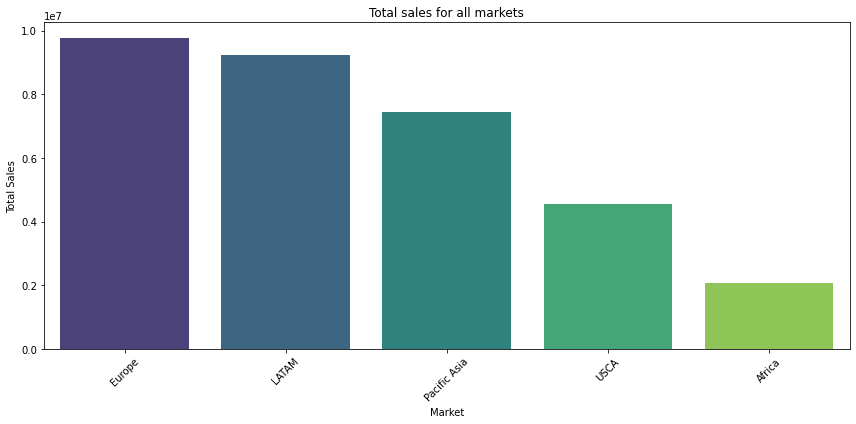

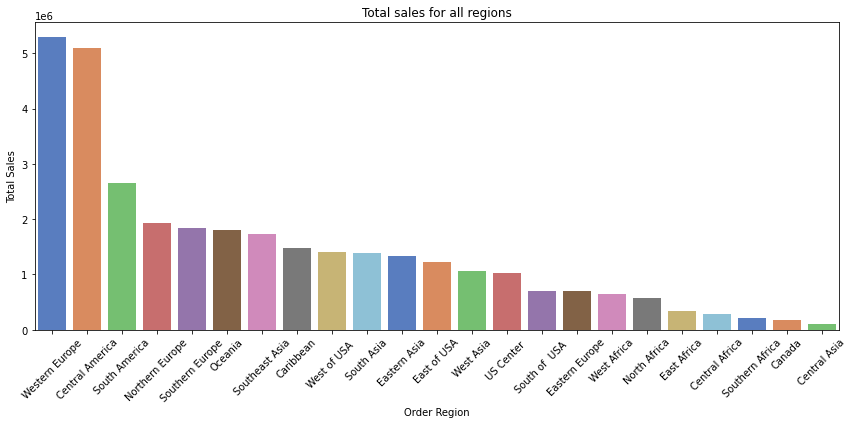

In [6]:
# Grouping by market and region
market = data.groupby('Market')['Sales per customer'].sum().sort_values(ascending=False)
region = data.groupby('Order Region')['Sales per customer'].sum().sort_values(ascending=False)

# Plotting the bar charts using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=market.index, y=market.values, palette='viridis')
plt.title("Total sales for all markets")
plt.xlabel("Market")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=region.index, y=region.values, palette='muted')
plt.title("Total sales for all regions")
plt.xlabel("Order Region")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


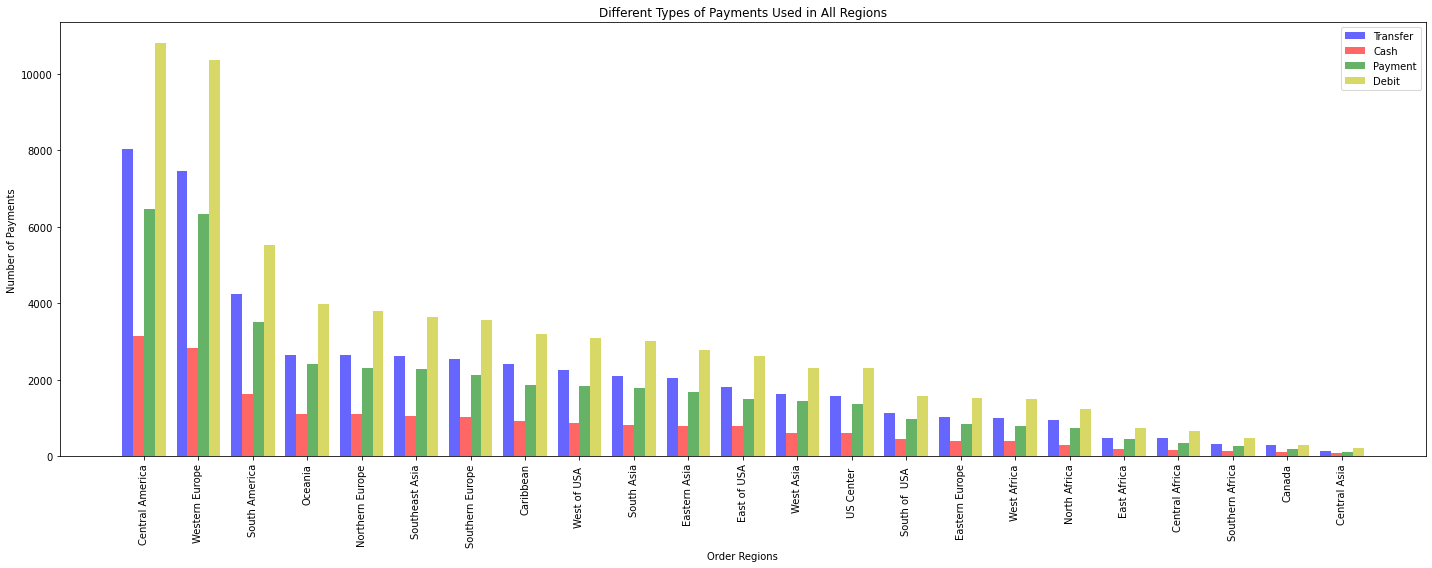

In [7]:
types = ['TRANSFER', 'CASH', 'PAYMENT', 'DEBIT']
colors = ['b', 'r', 'g', 'y']
type_labels = ['Transfer', 'Cash', 'Payment', 'Debit']

fig, ax = plt.subplots(figsize=(20, 8))

n_groups = 23
bar_width = 0.2
opacity = 0.6

index = np.arange(n_groups)

for i, t in enumerate(types):
    xyz = data[data['Type'] == t]
    count = xyz['Order Region'].value_counts()
    plt.bar(index + i * bar_width, count, bar_width, alpha=opacity, color=colors[i], label=type_labels[i])

plt.xlabel('Order Regions')
plt.ylabel('Number of Payments')
plt.title('Different Types of Payments Used in All Regions')
plt.legend()
plt.xticks(index + bar_width * (len(types) - 1) / 2, data['Order Region'].value_counts().keys(), rotation=90)
plt.tight_layout()
plt.show()

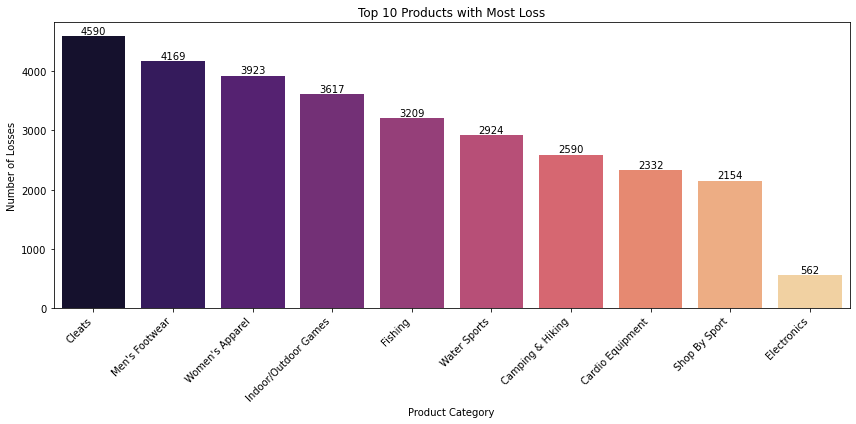

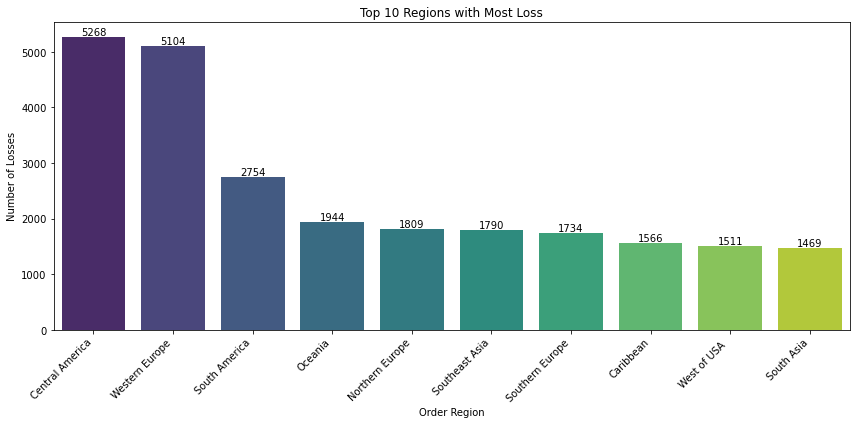

Total revenue lost with orders: -3883547.345768667


In [8]:
# Filtering data for loss
loss = data[data['Benefit per order'] < 0]

# Plotting top 10 products with most loss
plt.figure(figsize=(12, 6))
top_products = loss['Category Name'].value_counts().nlargest(10)
sns.barplot(x=top_products.index, y=top_products.values, palette='magma')
plt.title("Top 10 Products with Most Loss")
plt.xlabel("Product Category")
plt.ylabel("Number of Losses")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adding annotations to the bars
for index, value in enumerate(top_products.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

# Plotting top 10 regions with most loss
plt.figure(figsize=(12, 6))
top_regions = loss['Order Region'].value_counts().nlargest(10)
sns.barplot(x=top_regions.index, y=top_regions.values, palette='viridis')
plt.title("Top 10 Regions with Most Loss")
plt.xlabel("Order Region")
plt.ylabel("Number of Losses")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adding annotations to the bars
for index, value in enumerate(top_regions.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

# Sum of total sales which are lost
total_loss = loss['Benefit per order'].sum()
print('Total revenue lost with orders:', total_loss)


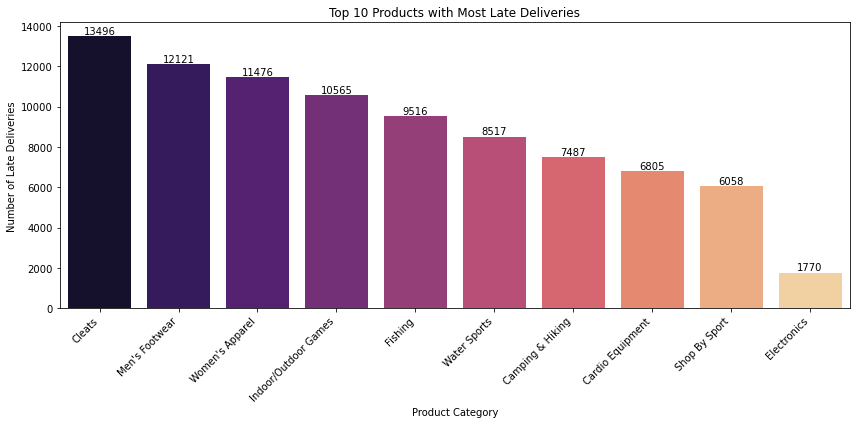

In [9]:
# Filtering data for late delivery
late_delivery = data[data['Delivery Status'] == 'Late delivery']

# Top 10 products with most late deliveries
plt.figure(figsize=(12, 6))
top_products = late_delivery['Category Name'].value_counts().nlargest(10)
sns.barplot(x=top_products.index, y=top_products.values, palette='magma')
plt.title("Top 10 Products with Most Late Deliveries")
plt.xlabel("Product Category")
plt.ylabel("Number of Late Deliveries")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adding annotations to the bars
for index, value in enumerate(top_products.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


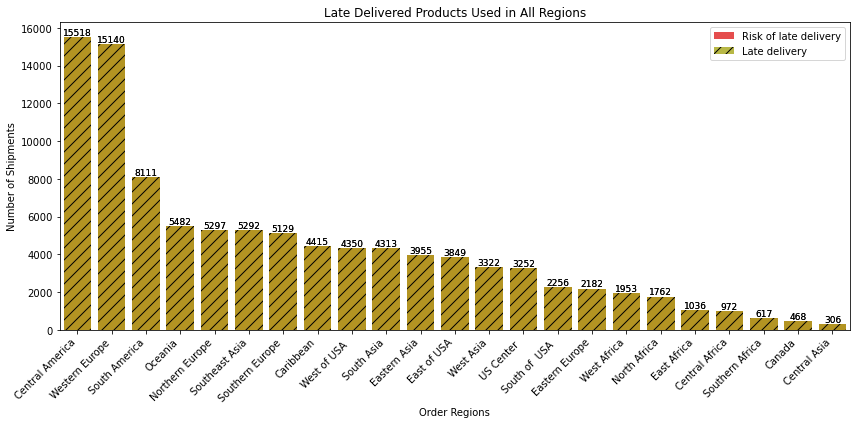

In [10]:
# Filtering orders with late delivery risk
xyz1 = data[data['Late_delivery_risk'] == 1]

# Filtering late delivered orders
xyz2 = data[data['Delivery Status'] == 'Late delivery']

# Counting the number of shipments for each order region in both categories
count1 = xyz1['Order Region'].value_counts()
count2 = xyz2['Order Region'].value_counts()

# Index names
names = data['Order Region'].value_counts().keys()

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and opacity
bar_width = 0.4
opacity = 0.8

# Plotting the bar charts using seaborn
sns.barplot(x=names, y=count1, alpha=opacity, color='r', label='Risk of late delivery')
sns.barplot(x=names, y=count2, alpha=opacity, color='y', label='Late delivery', hatch='//')

# Adding annotations to the bars
for i, value in enumerate(count1.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=9)

for i, value in enumerate(count2.values):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=9)

plt.xlabel('Order Regions')
plt.ylabel('Number of Shipments')
plt.title('Late Delivered Products Used in All Regions')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


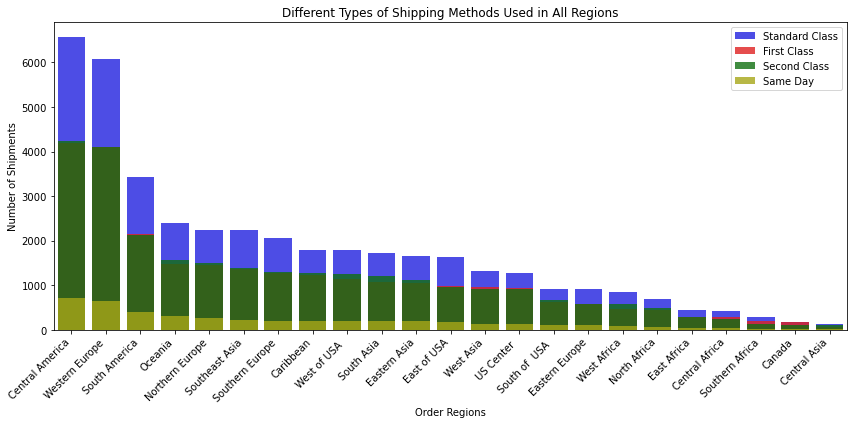

In [11]:
# Filtering late delivery orders with different shipping modes
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]

# Counting the number of shipments for each order region in each shipping mode
count1 = xyz1['Order Region'].value_counts()
count2 = xyz2['Order Region'].value_counts()
count3 = xyz3['Order Region'].value_counts()
count4 = xyz4['Order Region'].value_counts()

# Index names
names = data['Order Region'].value_counts().keys()

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width and opacity
bar_width = 0.15
opacity = 0.8

# Plotting the bar charts using seaborn
sns.barplot(x=names, y=count1, alpha=opacity, color='b', label='Standard Class')
sns.barplot(x=names, y=count2, alpha=opacity, color='r', label='First Class')
sns.barplot(x=names, y=count3, alpha=opacity, color='g', label='Second Class')
sns.barplot(x=names, y=count4, alpha=opacity, color='y', label='Same Day')

plt.xlabel('Order Regions')
plt.ylabel('Number of Shipments')
plt.title('Different Types of Shipping Methods Used in All Regions')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Data Modelling

In [12]:
train_data=data.copy()

In [13]:
#Dropping columns with repeated values
train_data.drop(['Late_delivery_risk','order date (DateOrders)',
                'Days for shipping (real)','Days for shipment (scheduled)','Category Id','Sales',
                'Customer Id','Department Id','Order Customer Id','Order Id',
                'Order Item Cardprod Id','Order Item Id','Product Card Id','Product Category Id',
                'Order Item Product Price','Benefit per order','Sales per customer',
                 'Order Item Product Price'
                ], axis=1, inplace=True)

In [14]:
train_data_corr=data.copy()

In [15]:
#Dropping columns with repeated values
train_data_corr.drop(['Late_delivery_risk','order date (DateOrders)',
                'Days for shipping (real)','Days for shipment (scheduled)','Category Id','Sales',
                'Customer Id','Department Id','Order Customer Id','Order Id',
                'Order Item Cardprod Id','Order Item Id','Product Card Id','Product Category Id',
                'Order Item Product Price','Benefit per order','Sales per customer',
                 'Order Item Product Price','Order Item Quantity'
                ], axis=1, inplace=True)

<AxesSubplot:>

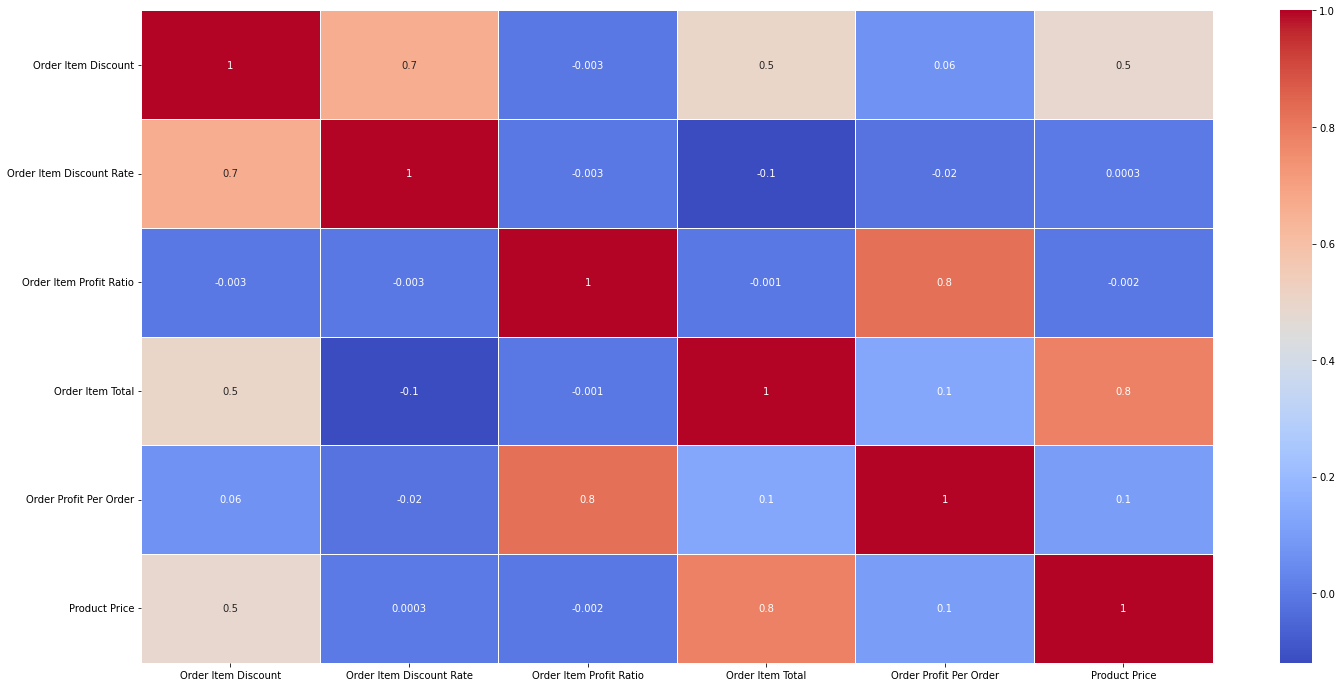

In [16]:
fig, ax = plt.subplots(figsize=(24,12))
sns.heatmap(train_data_corr.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix


In [17]:
# Columns to label encode
columns_to_encode = ['Type', 'Category Name','Customer City','Customer Country','Customer Segment',
                    'Customer State','Department Name','Market','Order City','Order Country','Order Region',
                    'Order State','Order Status','Product Name','Shipping Mode','Delivery Status']

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Loop through each column and perform label encoding
for col in columns_to_encode:
    train_data[col] = label_encoder.fit_transform(train_data[col])

## Comparision of Regression Models

In [18]:
X = train_data.loc[:, train_data.columns != 'Order Item Quantity']
y = train_data['Order Item Quantity']
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 123)

In [19]:
X_train.shape

(144415, 22)

In [20]:
X_test.shape

(36104, 22)

In [21]:
X_train.columns

Index(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Segment', 'Customer State',
       'Department Name', 'Market', 'Order City', 'Order Country',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Profit Ratio', 'Order Item Total', 'Order Profit Per Order',
       'Order Region', 'Order State', 'Order Status', 'Product Name',
       'Product Price', 'Shipping Mode'],
      dtype='object')

In [22]:
def regressionmodel(model_fitted,X_train, X_test,y_train,y_test):
    
    model_fitted = model_fitted.fit(X_train,y_train)
    
    y_pred = model_fitted.predict(X_test)
    
    #Printing mean absolute error for predicting order quantity
    print("MAE of order quantity   :", metrics.mean_absolute_error(y_test,y_pred))
    
    #Printing Root mean squared error for predicting order quantity
    print("RMSE of order quantity  :",np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

### Lasso Regression

In [23]:
model_fitted = linear_model.Lasso(alpha=0.1)
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.37123356129902463
RMSE of order quantity  : 0.5507129743317994


### Ridge Regression

In [24]:
model_fitted = Ridge(alpha=1.0)
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.36878096864937254
RMSE of order quantity  : 0.549347669976676


### Random Forest Regression

In [25]:
model_fitted = RandomForestRegressor(n_estimators=100,random_state=123)
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.0005007755373365821
RMSE of order quantity  : 0.008637837190622914


### XGB Boosting Regression

In [26]:
model_fitted = xgb.XGBRegressor()
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.003728107398810472
RMSE of order quantity  : 0.013733763621742093


### Decision Tree Regression

In [27]:
model_fitted = tree.DecisionTreeRegressor(random_state=123)
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.00013848881010414358
RMSE of order quantity  : 0.011768126873217486


### Best Model

In [28]:
model_fitted = RandomForestRegressor(n_estimators=100,random_state=123)
regressionmodel(model_fitted,X_train, X_test,y_train,y_test)

MAE of order quantity   : 0.0005007755373365821
RMSE of order quantity  : 0.008637837190622914


In [29]:
y_pred = model_fitted.predict(X_test)

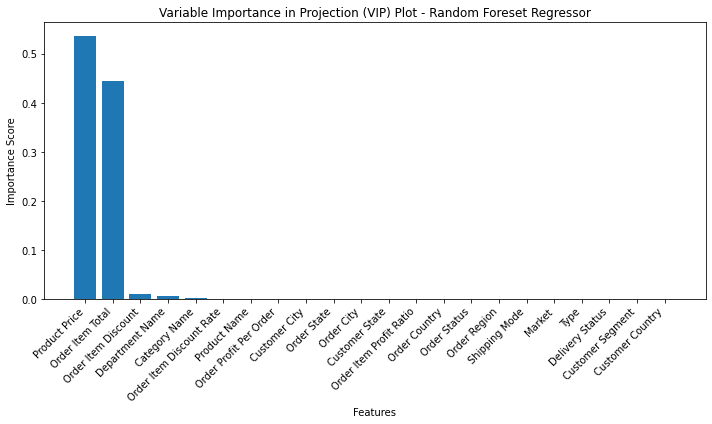

In [30]:
# Getting feature importances (approximation using mean decrease impurity)
importances = model_fitted.feature_importances_

# Sorting indices of features by importance
indices = np.argsort(importances)[::-1]

# Getting feature names for plotting
feature_names = list(X.columns)

# Creating VIP plot
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Variable Importance in Projection (VIP) Plot - Random Foreset Regressor')
plt.tight_layout()
plt.show()